1.Load Data

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

railcar_demand_df = pd.read_csv('New_Railcar_Demand.csv')
carloads_df = pd.read_csv('Carloads.csv')

# Display basic info to understand the data structure
print(railcar_demand_df.head())
print(carloads_df.head())

<ipython-input-1-a19eaea29e7e>:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


         Date  North America Backlog__TOTAL_incl_Auto_Racks  \
0  2000-04-01                                         30825   
1  2000-07-01                                         28176   
2  2000-10-01                                         26218   
3  2001-01-01                                         22648   
4  2001-04-01                                         19991   

   North America Deliveries__TOTAL_incl _Auto_Racks  \
0                                             16867   
1                                             14179   
2                                             12782   
3                                             11993   
4                                             11070   

   North America Orders__TOTAL_incl _Auto_Racks  \
0                                         14551   
1                                         11595   
2                                         11211   
3                                          8478   
4                                  

2.Exploratory Data Analysis

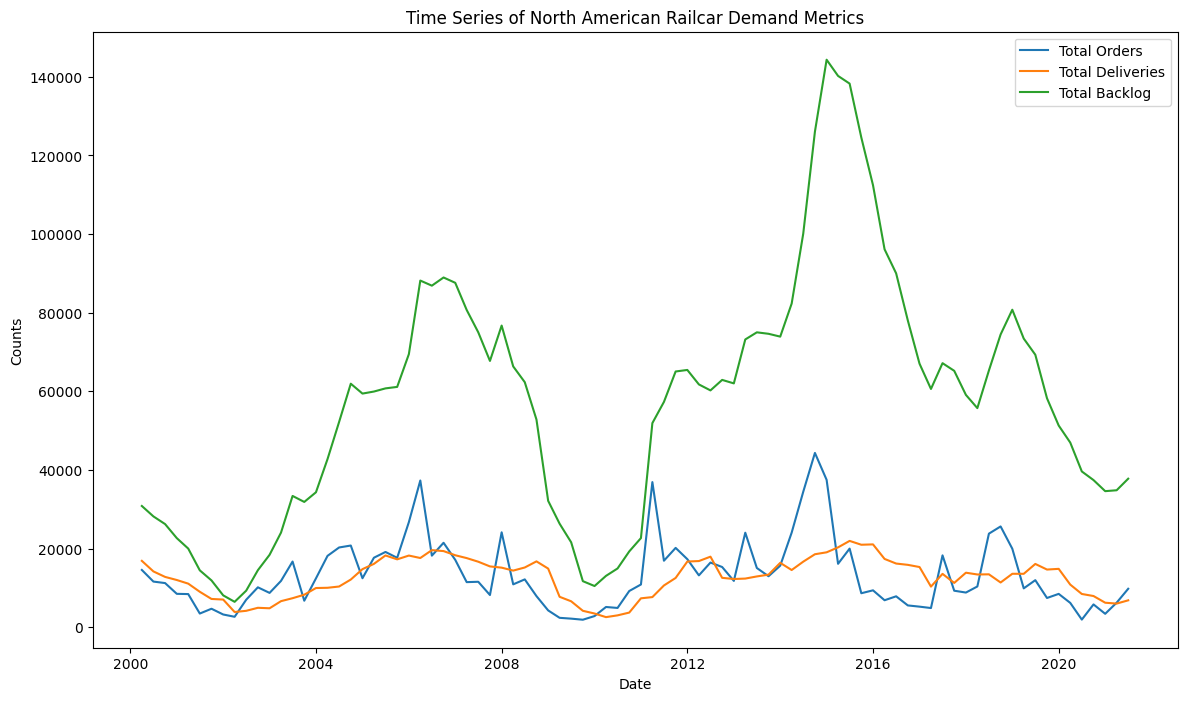

(All Other Carloads               -0.065066
 Chemicals                         0.210334
 Coal                              0.190603
 Coke                              0.380160
 Containers                        0.163864
 Crushed_Stone_ Sand__Gravel       0.330563
 Farm Products  Excluding Grain   -0.023505
 Food Products                     0.048138
 Grain                            -0.038753
 Grain Mill Products               0.097970
 Iron and Steel Scrap1             0.021389
 Lumber__Wood                      0.187523
 Metallic Ores                     0.308202
 Motor_Vehicles__Parts             0.121502
 Nonmetallic Minerals              0.031292
 Petroleum Products                0.290469
 Primary Forest Products          -0.018993
 Primary Metal Products            0.399553
 Pulp__Paper                       0.145213
 Stone_Clay__Glass_Products        0.173320
 Total Cars + Intermodal           0.579705
 Total Intermodal                  0.252691
 Trailers                       

In [2]:
# Total Orders, Deliveries, and Backlog
import matplotlib.pyplot as plt

# Convert Date columns to datetime format
carloads_df['Date'] = pd.to_datetime(carloads_df['Date'])
railcar_demand_df['Date'] = pd.to_datetime(railcar_demand_df['Date'])

# Set Date as index for easier time series analysis
carloads_df.set_index('Date', inplace=True)
railcar_demand_df.set_index('Date', inplace=True)

# Plot time series for the main variables in New Railcar Demand data
plt.figure(figsize=(14, 8))
plt.plot(railcar_demand_df.index, railcar_demand_df['North America Orders__TOTAL_incl _Auto_Racks'], label='Total Orders')
plt.plot(railcar_demand_df.index, railcar_demand_df['North America Deliveries__TOTAL_incl _Auto_Racks'], label='Total Deliveries')
plt.plot(railcar_demand_df.index, railcar_demand_df['North America Backlog__TOTAL_incl_Auto_Racks'], label='Total Backlog')
plt.xlabel('Date')
plt.ylabel('Counts')
plt.title('Time Series of North American Railcar Demand Metrics')
plt.legend()
plt.show()

# Correlation analysis between carloads and overall orders/deliveries/backlog
carloads_corr = carloads_df.corrwith(railcar_demand_df['North America Orders__TOTAL_incl _Auto_Racks'])
deliveries_corr = carloads_df.corrwith(railcar_demand_df['North America Deliveries__TOTAL_incl _Auto_Racks'])
backlog_corr = carloads_df.corrwith(railcar_demand_df['North America Backlog__TOTAL_incl_Auto_Racks'])

# Display correlations with Orders, Deliveries, and Backlog
carloads_corr, deliveries_corr, backlog_corr

Descriptive Statistics - Orders, Deliveries, and Backlog (Covered Hoppers & Tankcars):
       North America - Covered Hoppers - Orders  \
count                                 86.000000   
mean                                1199.686047   
std                                 1188.445453   
min                                    5.000000   
25%                                  273.000000   
50%                                  752.500000   
75%                                 1649.500000   
max                                 5312.000000   

       North America - Tankcars - Orders  \
count                          86.000000   
mean                         4180.918605   
std                          3907.778181   
min                           693.000000   
25%                          1444.250000   
50%                          2952.000000   
75%                          5090.750000   
max                         19267.000000   

       North America - Covered Hoppers - Deliveries  \
c

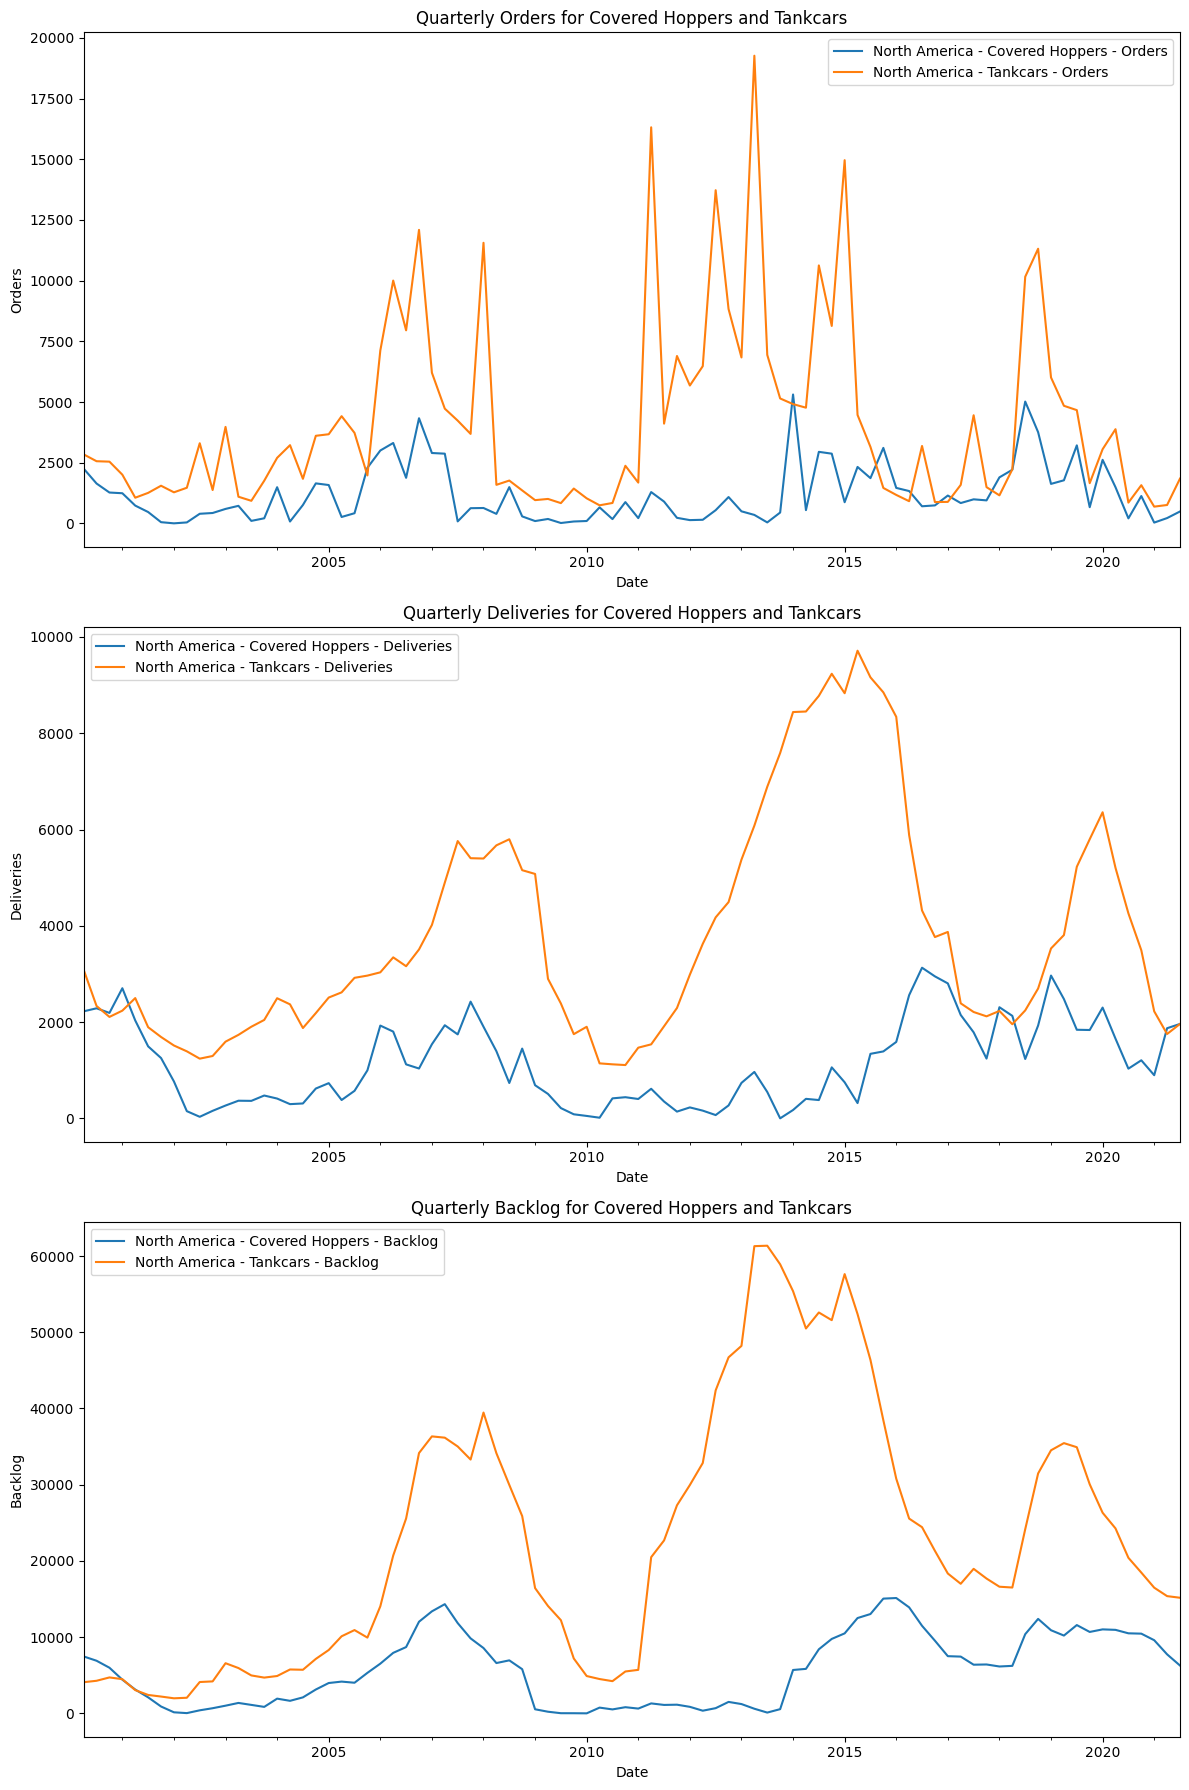

In [3]:
# Descriptive Analysis of Industry Orders, Deliveries, and Backlog by 2 car types
print("Descriptive Statistics - Orders, Deliveries, and Backlog (Covered Hoppers & Tankcars):")
print(railcar_demand_df[['North America - Covered Hoppers - Orders', 
                         'North America - Tankcars - Orders',
                         'North America - Covered Hoppers - Deliveries', 
                         'North America - Tankcars - Deliveries',
                         'North America - Covered Hoppers - Backlog', 
                         'North America - Tankcars - Backlog']].describe())

# Plot Orders, Deliveries, and Backlog trends for Covered Hoppers and Tankcars
fig, axs = plt.subplots(3, 1, figsize=(12, 18))

railcar_demand_df[['North America - Covered Hoppers - Orders', 'North America - Tankcars - Orders']].plot(ax=axs[0])
axs[0].set_title("Quarterly Orders for Covered Hoppers and Tankcars")
axs[0].set_ylabel("Orders")

railcar_demand_df[['North America - Covered Hoppers - Deliveries', 'North America - Tankcars - Deliveries']].plot(ax=axs[1])
axs[1].set_title("Quarterly Deliveries for Covered Hoppers and Tankcars")
axs[1].set_ylabel("Deliveries")

railcar_demand_df[['North America - Covered Hoppers - Backlog', 'North America - Tankcars - Backlog']].plot(ax=axs[2])
axs[2].set_title("Quarterly Backlog for Covered Hoppers and Tankcars")
axs[2].set_ylabel("Backlog")

plt.tight_layout()
plt.show()

In [4]:
# Exogenous Feature Identification
# Aggregate carloads data to quarterly frequency using 'Q-DEC' for quarter-end in December
carloads_quarterly = carloads_df.resample('Q-DEC').sum()

# Calculate correlation between carloads and railcar Orders & Deliveries for each car type
correlations_orders_covered_hoppers = carloads_quarterly.corrwith(railcar_demand_df['North America - Covered Hoppers - Orders'])
correlations_orders_tankcars = carloads_quarterly.corrwith(railcar_demand_df['North America - Tankcars - Orders'])

correlations_deliveries_covered_hoppers = carloads_quarterly.corrwith(railcar_demand_df['North America - Covered Hoppers - Deliveries'])
correlations_deliveries_tankcars = carloads_quarterly.corrwith(railcar_demand_df['North America - Tankcars - Deliveries'])

# Select top correlated features for each demand variable
top_exogenous_orders_hoppers = correlations_orders_covered_hoppers.sort_values(ascending=False).head(5).index.tolist()
top_exogenous_orders_tankcars = correlations_orders_tankcars.sort_values(ascending=False).head(5).index.tolist()
top_exogenous_deliveries_hoppers = correlations_deliveries_covered_hoppers.sort_values(ascending=False).head(5).index.tolist()
top_exogenous_deliveries_tankcars = correlations_deliveries_tankcars.sort_values(ascending=False).head(5).index.tolist()
# Display top features
print("Top Exogenous Features for Covered Hoppers Orders:\n", top_exogenous_orders_hoppers)
print("Top Exogenous Features for Tankcars Orders:\n", top_exogenous_orders_tankcars)
print("Top Exogenous Features for Covered Hoppers Deliveries:\n", top_exogenous_deliveries_hoppers)
print("Top Exogenous Features for Tankcars Deliveries:\n", top_exogenous_deliveries_tankcars)

<ipython-input-4-f1434d8ce7f7>:3: FutureWarning: 'Q-DEC' is deprecated and will be removed in a future version, please use 'QE-DEC' instead.
  carloads_quarterly = carloads_df.resample('Q-DEC').sum()


Top Exogenous Features for Covered Hoppers Orders:
 ['All Other Carloads', 'Chemicals', 'Coal', 'Coke', 'Containers']
Top Exogenous Features for Tankcars Orders:
 ['All Other Carloads', 'Chemicals', 'Coal', 'Coke', 'Containers']
Top Exogenous Features for Covered Hoppers Deliveries:
 ['All Other Carloads', 'Chemicals', 'Coal', 'Coke', 'Containers']
Top Exogenous Features for Tankcars Deliveries:
 ['All Other Carloads', 'Chemicals', 'Coal', 'Coke', 'Containers']


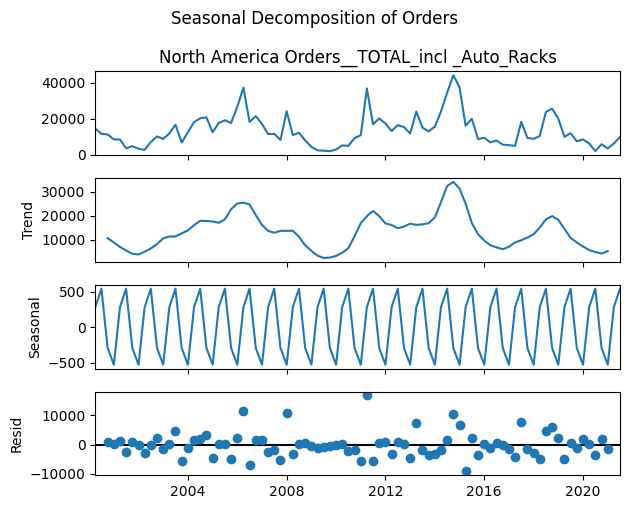

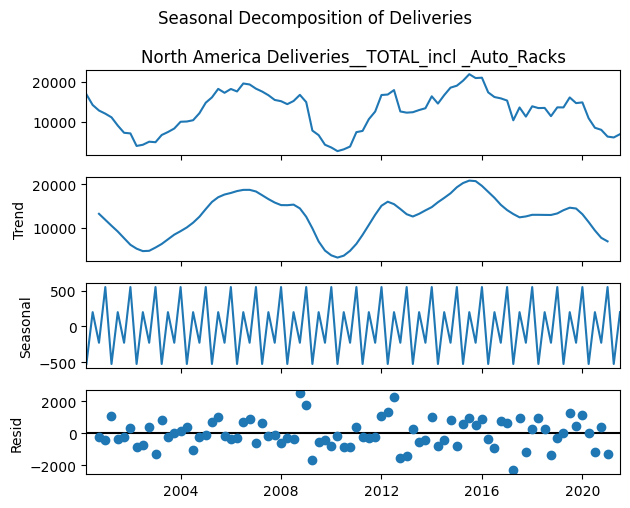

In [5]:
# seasonality
from statsmodels.tsa.seasonal import seasonal_decompose

# Select the Orders and Deliveries series
orders_series = railcar_demand_df['North America Orders__TOTAL_incl _Auto_Racks']
deliveries_series = railcar_demand_df['North America Deliveries__TOTAL_incl _Auto_Racks']

# Perform seasonal decomposition for Orders
orders_decomposition = seasonal_decompose(orders_series, model='additive', period=4)  # Assuming quarterly data
orders_decomposition.plot()
plt.suptitle('Seasonal Decomposition of Orders', y=1.05)
plt.show()

# Perform seasonal decomposition for Deliveries
deliveries_decomposition = seasonal_decompose(deliveries_series, model='additive', period=4)  # Assuming quarterly data
deliveries_decomposition.plot()
plt.suptitle('Seasonal Decomposition of Deliveries', y=1.05)
plt.show()

Interpretation of the Components:
Observed: The original data, displaying overall trends and fluctuations in demand.
Trend: Shows the long-term increase or decrease in railcar demand. This component can help identify whether demand is growing, declining, or stable over time.
Seasonal: Captures the repeating pattern on a quarterly basis, highlighting seasonal cycles in the demand for railcars. If there is a consistent pattern, it indicates seasonality in demand across different quarters.
Residual: The noise or random fluctuations in the data that are not explained by the trend or seasonal components.

Identify Relevant Macro Economics Variables: 
Railcar demand is influenced by macroeconomic and sector-specific indicators, especially those related to industrial activity, freight transportation, and commodity prices. Here’s a selection of indicators that could provide valuable insights:

Gross Domestic Product (GDP): A general measure of economic health; growth in GDP often correlates with higher demand for goods transportation.
Industrial Production Index (INDPRO): Reflects manufacturing output, which impacts demand for rail transport.
Freight Shipments Index: Directly related to demand for transportation and logistics services.
Commodity Prices (e.g., metals, energy, agriculture): Railcars often transport bulk commodities, so prices in these sectors can impact demand.

In [6]:
# Load external data 
gdp_data = pd.read_csv('GDP.csv', parse_dates=['DATE'], index_col='DATE')
industrial_production = pd.read_csv('INDPRO.csv', parse_dates=['DATE'], index_col='DATE')
freight_shipments = pd.read_csv('FRGSHP.csv', parse_dates=['DATE'], index_col='DATE')
commodity_prices = pd.read_csv('PPIIDC.csv', parse_dates=['DATE'], index_col='DATE')

# Convert to quarterly frequency
gdp_data = gdp_data.resample('Q').mean()
industrial_production = industrial_production.resample('Q').mean()
freight_shipments = freight_shipments.resample('Q').mean()
commodity_prices = commodity_prices.resample('Q').mean()

# Combine these indicators into a single DataFrame for integration
exogenous_indicators = pd.DataFrame({
    'GDP': gdp_data['GDP'],
    'Industrial_Production': industrial_production['INDPRO'],
    'Freight_Shipments': freight_shipments['FRGSHPUSM649NCIS'],
    'Commodity_Prices': commodity_prices['PPIIDC']  
})

# Align the exogenous indicators with your railcar demand data's date range
railcar_demand_data = pd.read_csv('New_Railcar_Demand.csv', parse_dates=['Date'], index_col='Date')
aligned_exogenous = exogenous_indicators.loc[railcar_demand_data.index.min():railcar_demand_data.index.max()]

# Integrate with existing railcar demand data
exogenous_features_covered_hopper = aligned_exogenous.copy()
exogenous_features_tankcar = aligned_exogenous.copy()

<ipython-input-6-1c066cb255ac>:8: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  gdp_data = gdp_data.resample('Q').mean()
<ipython-input-6-1c066cb255ac>:9: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  industrial_production = industrial_production.resample('Q').mean()
<ipython-input-6-1c066cb255ac>:10: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freight_shipments = freight_shipments.resample('Q').mean()
<ipython-input-6-1c066cb255ac>:11: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  commodity_prices = commodity_prices.resample('Q').mean()


In [7]:
railcar_demand_data = railcar_demand_data.rename(columns={
    'North America - Covered Hoppers - Orders': 'Covered_Hopper_Orders',
    'North America - Tankcars - Orders': 'Tankcar_Orders'
})

# Perform correlation analysis
correlations_covered_hopper = exogenous_features_covered_hopper.corrwith(railcar_demand_data['Covered_Hopper_Orders'])
correlations_tankcar = exogenous_features_tankcar.corrwith(railcar_demand_data['Tankcar_Orders'])

print("Correlations with Covered Hopper Orders:\n", correlations_covered_hopper)
print("Correlations with Tankcar Orders:\n", correlations_tankcar)

Correlations with Covered Hopper Orders:
 GDP                     NaN
Industrial_Production   NaN
Freight_Shipments       NaN
Commodity_Prices        NaN
dtype: float64
Correlations with Tankcar Orders:
 GDP                     NaN
Industrial_Production   NaN
Freight_Shipments       NaN
Commodity_Prices        NaN
dtype: float64


Causal Justification
GDP and Industrial Production are justified by economic theory, as growth in these indicators generally signals increased industrial and manufacturing activity, which often results in higher demand for freight and railcar transportation.
Freight Shipments Index is directly related to logistics and transportation demand, providing a direct measure of railcar demand drivers.
Commodity Prices influence railcar demand in sectors like metals, energy, and agriculture. Rising commodity prices can increase shipments as businesses stockpile or increase exports.

3.Build Predictive Models

In [8]:
# forecast Orders first
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load the datasets (replace with actual paths if necessary)
carloads_data = pd.read_csv('Carloads.csv')
railcar_demand_data = pd.read_csv('New_Railcar_Demand.csv')
gdp_data = pd.read_csv('GDP.csv', parse_dates=['DATE'], index_col='DATE')  # Load GDP data

# Convert Date columns to datetime format
carloads_data['Date'] = pd.to_datetime(carloads_data['Date'])
railcar_demand_data['Date'] = pd.to_datetime(railcar_demand_data['Date'])

# Set Date as index for both datasets
carloads_data.set_index('Date', inplace=True)
railcar_demand_data.set_index('Date', inplace=True)

# Aggregate carloads data to quarterly frequency, then adjust to quarter start
quarterly_carloads = carloads_data.resample('Q').sum()
quarterly_carloads.index = quarterly_carloads.index.to_period('Q').to_timestamp('S')

# Trim carloads data to start from 2000 to align with Orders data range
quarterly_carloads = quarterly_carloads[quarterly_carloads.index >= "2000-01-01"]

# Resample GDP data to quarterly frequency and set to the beginning of the quarter
gdp_data = gdp_data.resample('Q').mean()  # Resample to quarterly frequency
gdp_data.index = gdp_data.index.to_period('Q').to_timestamp('S')  # Change to quarter beginning

# Align GDP and Carloads data with Railcar Demand Data date range
# Define the target date range based on the overlapping period for all datasets
target_start = max(railcar_demand_data.index.min(), quarterly_carloads.index.min(), gdp_data.index.min())
target_end = min(railcar_demand_data.index.max(), quarterly_carloads.index.max(), gdp_data.index.max())

# Trim all datasets to the common date range
railcar_demand_data = railcar_demand_data.loc[target_start:target_end]
quarterly_carloads = quarterly_carloads.loc[target_start:target_end]
gdp_data = gdp_data.loc[target_start:target_end]  # Renaming gdp_data instead of using gdp_data_aligned

# Check shapes and date ranges after alignment
print("Railcar Demand Data Shape:", railcar_demand_data.shape)
print("Quarterly Carloads Data Shape:", quarterly_carloads.shape)
print("GDP Data Shape:", gdp_data.shape)

# Fill any remaining missing values in GDP if necessary (e.g., using forward and backward fill)
gdp_data = gdp_data.fillna(method='ffill').fillna(method='bfill')

# Define target variables for Orders (Covered Hoppers and Tankcars)
covered_hopper_orders = railcar_demand_data['North America - Covered Hoppers - Orders']
tankcar_orders = railcar_demand_data['North America - Tankcars - Orders']

# Select relevant exogenous features and add GDP
exogenous_features_covered_hopper = quarterly_carloads[['All Other Carloads', 'Chemicals', 'Coal', 'Coke', 'Containers']]
exogenous_features_covered_hopper['GDP'] = gdp_data['GDP']  # Include GDP in exogenous features

exogenous_features_tankcar = quarterly_carloads[['All Other Carloads', 'Chemicals', 'Coal', 'Coke', 'Containers']]
exogenous_features_tankcar['GDP'] = gdp_data['GDP']  # Include GDP in exogenous features

# Align data by joining the Orders data with the contemporaneous exogenous features
covered_hopper_data = pd.concat([covered_hopper_orders, exogenous_features_covered_hopper], axis=1).dropna()
tankcar_data = pd.concat([tankcar_orders, exogenous_features_tankcar], axis=1).dropna()

# Rename target columns for clarity
covered_hopper_data.rename(columns={'North America - Covered Hoppers - Orders': 'target'}, inplace=True)
tankcar_data.rename(columns={'North America - Tankcars - Orders': 'target'}, inplace=True)

# Split into train and test sets
train_size = int(len(covered_hopper_data) * 0.8)
covered_train, covered_test = covered_hopper_data[:train_size], covered_hopper_data[train_size:]
tankcar_train, tankcar_test = tankcar_data[:train_size], tankcar_data[train_size:]

# Prepare train/test data for XGBoost
X_train_covered, y_train_covered = covered_train.drop(columns='target'), covered_train['target']
X_test_covered, y_test_covered = covered_test.drop(columns='target'), covered_test['target']

X_train_tankcar, y_train_tankcar = tankcar_train.drop(columns='target'), tankcar_train['target']
X_test_tankcar, y_test_tankcar = tankcar_test.drop(columns='target'), tankcar_test['target']

# Train XGBoost models for Orders (including GDP as a feature)
xgb_model_covered = XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=3, learning_rate=0.1)
xgb_model_covered.fit(X_train_covered, y_train_covered)

xgb_model_tankcar = XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=3, learning_rate=0.1)
xgb_model_tankcar.fit(X_train_tankcar, y_train_tankcar)

# Forecast Orders for test set
covered_forecast = xgb_model_covered.predict(X_test_covered)
tankcar_forecast = xgb_model_tankcar.predict(X_test_tankcar)

# Evaluate model performance
mae_covered = mean_absolute_error(y_test_covered, covered_forecast)
rmse_covered = np.sqrt(mean_squared_error(y_test_covered, covered_forecast))

mae_tankcar = mean_absolute_error(y_test_tankcar, tankcar_forecast)
rmse_tankcar = np.sqrt(mean_squared_error(y_test_tankcar, tankcar_forecast))

print("Covered Hoppers Orders - MAE:", mae_covered, "RMSE:", rmse_covered)
print("Tankcars Orders - MAE:", mae_tankcar, "RMSE:", rmse_tankcar)

# Display sample predictions for Covered Hoppers and Tankcars Orders
print("Covered Hoppers Orders Predictions:", covered_forecast[:5])
print("Tankcars Orders Predictions:", tankcar_forecast[:5])

<ipython-input-8-24363fd14bf6>:19: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly_carloads = carloads_data.resample('Q').sum()
<ipython-input-8-24363fd14bf6>:20: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  quarterly_carloads.index = quarterly_carloads.index.to_period('Q').to_timestamp('S')
<ipython-input-8-24363fd14bf6>:26: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  gdp_data = gdp_data.resample('Q').mean()  # Resample to quarterly frequency
<ipython-input-8-24363fd14bf6>:27: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  gdp_data.index = gdp_data.index.to_period('Q').to_timestamp('S')  # Change to quarter beginning


Railcar Demand Data Shape: (86, 9)
Quarterly Carloads Data Shape: (86, 25)
GDP Data Shape: (86, 1)


<ipython-input-8-24363fd14bf6>:45: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  gdp_data = gdp_data.fillna(method='ffill').fillna(method='bfill')
<ipython-input-8-24363fd14bf6>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exogenous_features_covered_hopper['GDP'] = gdp_data['GDP']  # Include GDP in exogenous features
<ipython-input-8-24363fd14bf6>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exogenous_featu

Covered Hoppers Orders - MAE: 1096.5054524739583 RMSE: 1453.9821687560918
Tankcars Orders - MAE: 2379.1762898763022 RMSE: 3749.4065030727643
Covered Hoppers Orders Predictions: [ 875.5036 1266.2026 1535.0919  875.5036 1718.2589]
Tankcars Orders Predictions: [1043.0864 1637.5623 1347.4241 1153.9589 1079.5518]


In [9]:
# Define target variables for Deliveries and Backlog based on railcar_demand_data
covered_hopper_deliveries = railcar_demand_data['North America - Covered Hoppers - Deliveries']
tankcar_deliveries = railcar_demand_data['North America - Tankcars - Deliveries']

covered_hopper_backlog = railcar_demand_data['North America - Covered Hoppers - Backlog']
tankcar_backlog = railcar_demand_data['North America - Tankcars - Backlog']

# Function to create lagged features
def create_delivery_features(deliveries, orders, exog):
    # Check if deliveries, orders, and exogenous data are not empty and have the same length
    print("Deliveries shape:", deliveries.shape)
    print("Orders shape:", orders.shape)
    print("Exogenous features shape:", exog.shape)
    
    # Use actual historical Orders and exogenous features for Deliveries
    data = pd.DataFrame({'historical_orders': orders})
    for feature in exog.columns:
        data[feature] = exog[feature]
    data['target'] = deliveries

    # Check for missing values in the DataFrame before dropping
    print("Missing values before dropna:\n", data.isnull().sum())

    # Drop rows with any missing values
    data.dropna(inplace=True)

    # Check if data is sufficient after dropping NaN values
    print("Data shape after dropna:", data.shape)
    
    return data

# Step 1: Prepare Deliveries Models using only historical Orders
# Assuming covered_hopper_deliveries, covered_hopper_orders, exogenous_features_covered_hopper are defined
covered_hopper_deliveries_data = create_delivery_features(covered_hopper_deliveries, covered_hopper_orders, exogenous_features_covered_hopper)
tankcar_deliveries_data = create_delivery_features(tankcar_deliveries, tankcar_orders, exogenous_features_tankcar)

# Check if there is sufficient data for Deliveries models
if covered_hopper_deliveries_data.empty or tankcar_deliveries_data.empty:
    print("Error: Insufficient data after preparing data for Deliveries.")
else:
    # Split data into training and testing sets
    train_size_deliveries = int(len(covered_hopper_deliveries_data) * 0.8)
    covered_train_deliveries, covered_test_deliveries = covered_hopper_deliveries_data[:train_size_deliveries], covered_hopper_deliveries_data[train_size_deliveries:]
    tankcar_train_deliveries, tankcar_test_deliveries = tankcar_deliveries_data[:train_size_deliveries], tankcar_deliveries_data[train_size_deliveries:]

    # Train XGBoost models for Deliveries
    xgb_model_covered_deliveries = XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=3, learning_rate=0.1)
    xgb_model_covered_deliveries.fit(covered_train_deliveries.drop(columns='target'), covered_train_deliveries['target'])
    covered_forecast_deliveries = xgb_model_covered_deliveries.predict(covered_test_deliveries.drop(columns='target'))

    xgb_model_tankcar_deliveries = XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=3, learning_rate=0.1)
    xgb_model_tankcar_deliveries.fit(tankcar_train_deliveries.drop(columns='target'), tankcar_train_deliveries['target'])
    tankcar_forecast_deliveries = xgb_model_tankcar_deliveries.predict(tankcar_test_deliveries.drop(columns='target'))

    # Step 2: Calculate Backlog
    # Using the backlog formula with available predictions for Orders and Deliveries
    predicted_backlog_covered = [covered_hopper_backlog.iloc[train_size_deliveries - 1]]
    predicted_backlog_tankcar = [tankcar_backlog.iloc[train_size_deliveries - 1]]

    forecast_horizon = len(covered_forecast_deliveries)
    for i in range(forecast_horizon):
        backlog_covered = (predicted_backlog_covered[-1] + covered_forecast_deliveries[i])
        predicted_backlog_covered.append(backlog_covered)

        backlog_tankcar = (predicted_backlog_tankcar[-1] + tankcar_forecast_deliveries[i])
        predicted_backlog_tankcar.append(backlog_tankcar)

    # Convert backlog lists to Series for easier handling
    predicted_backlog_covered = pd.Series(predicted_backlog_covered[1:], name="Predicted Covered Hopper Backlog")
    predicted_backlog_tankcar = pd.Series(predicted_backlog_tankcar[1:], name="Predicted Tankcar Backlog")

    # Display results
    print("Predicted Covered Hopper Backlog for 3-Year Horizon:\n", predicted_backlog_covered)
    print("Predicted Tankcar Backlog for 3-Year Horizon:\n", predicted_backlog_tankcar)

Deliveries shape: (86,)
Orders shape: (86,)
Exogenous features shape: (86, 6)
Missing values before dropna:
 historical_orders     0
All Other Carloads    0
Chemicals             0
Coal                  0
Coke                  0
Containers            0
GDP                   0
target                0
dtype: int64
Data shape after dropna: (86, 8)
Deliveries shape: (86,)
Orders shape: (86,)
Exogenous features shape: (86, 6)
Missing values before dropna:
 historical_orders     0
All Other Carloads    0
Chemicals             0
Coal                  0
Coke                  0
Containers            0
GDP                   0
target                0
dtype: int64
Data shape after dropna: (86, 8)
Predicted Covered Hopper Backlog for 3-Year Horizon:
 0     10327.615479
1     13059.718994
2     15650.825439
3     18093.262939
4     20458.137939
5     23041.974609
6     25625.811279
7     28104.917725
8     29140.068604
9     31510.841064
10    32609.766235
11    33694.634644
12    34701.110535
13   

In [10]:
4.Evaluate Predictive Model Results & Report Findings

<class 'SyntaxError'>: invalid decimal literal (<ipython-input-10-db71f99e3df5>, line 1)

Covered Hoppers Deliveries - MAE: 1096.5054524739583 RMSE: 1453.9821687560918


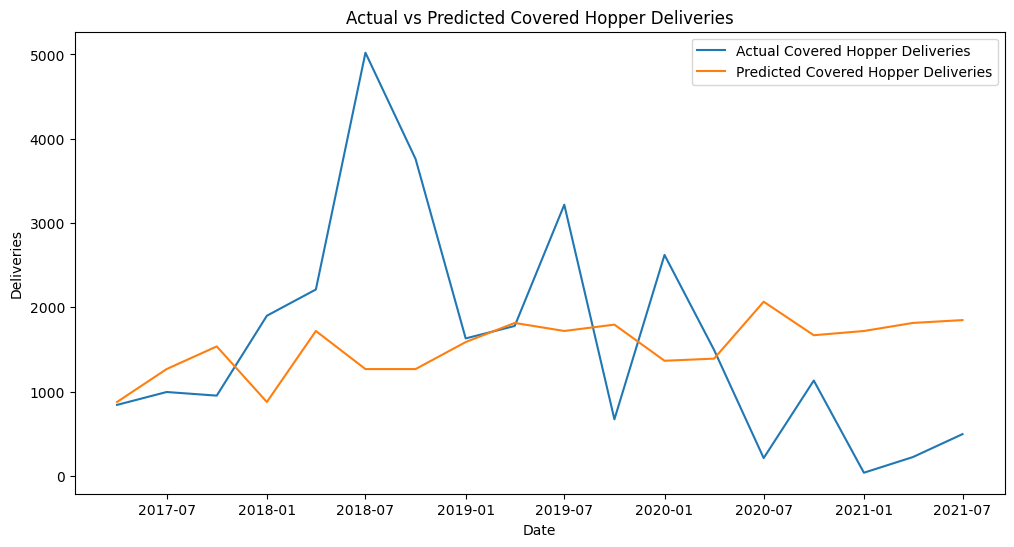

Tankcars Deliveries - MAE: 2379.1762898763022 RMSE: 3749.4065030727643


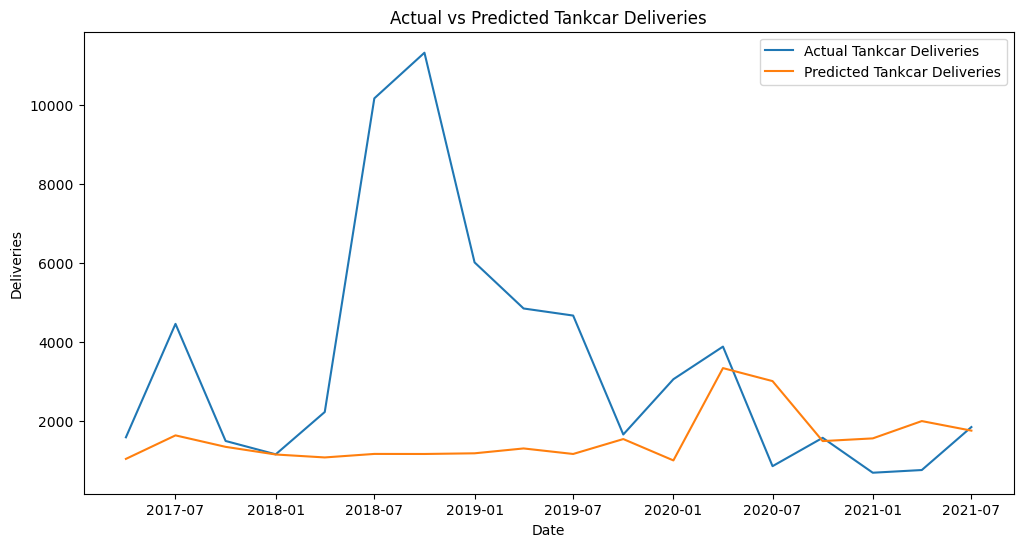

In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Evaluate model performance for Covered Hopper Deliveries
mae_covered = mean_absolute_error(y_test_covered, covered_forecast)
rmse_covered = np.sqrt(mean_squared_error(y_test_covered, covered_forecast))
print("Covered Hoppers Deliveries - MAE:", mae_covered, "RMSE:", rmse_covered)

# Plot Actual vs. Predicted for Covered Hopper Deliveries
plt.figure(figsize=(12, 6))
plt.plot(y_test_covered.index, y_test_covered, label='Actual Covered Hopper Deliveries')
plt.plot(y_test_covered.index, covered_forecast, label='Predicted Covered Hopper Deliveries')
plt.xlabel('Date')
plt.ylabel('Deliveries')
plt.title('Actual vs Predicted Covered Hopper Deliveries')
plt.legend()
plt.show()

# Evaluate model performance for Tankcar Deliveries
mae_tankcar = mean_absolute_error(y_test_tankcar, tankcar_forecast)
rmse_tankcar = np.sqrt(mean_squared_error(y_test_tankcar, tankcar_forecast))
print("Tankcars Deliveries - MAE:", mae_tankcar, "RMSE:", rmse_tankcar)

# Plot Actual vs. Predicted for Tankcar Deliveries
plt.figure(figsize=(12, 6))
plt.plot(y_test_tankcar.index, y_test_tankcar, label='Actual Tankcar Deliveries')
plt.plot(y_test_tankcar.index, tankcar_forecast, label='Predicted Tankcar Deliveries')
plt.xlabel('Date')
plt.ylabel('Deliveries')
plt.title('Actual vs Predicted Tankcar Deliveries')
plt.legend()
plt.show()

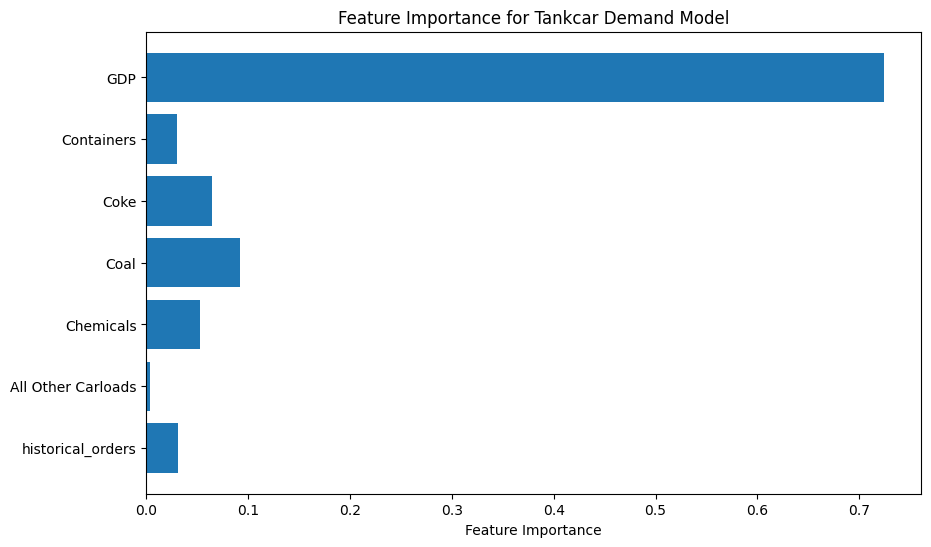

In [12]:
importances = xgb_model_tankcar_deliveries.feature_importances_

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(tankcar_train_deliveries.drop(columns='target').columns, importances)
plt.xlabel("Feature Importance")
plt.title("Feature Importance for Tankcar Demand Model")
plt.show()

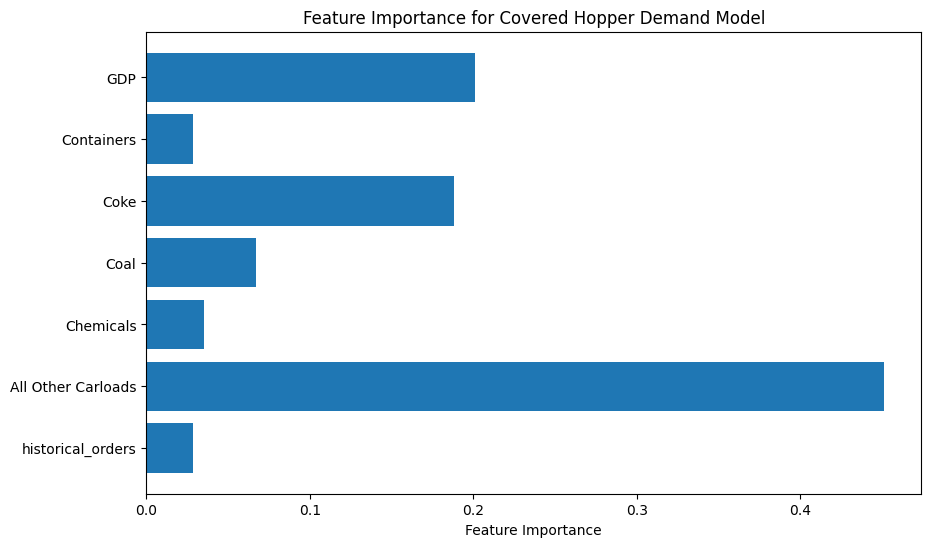

In [13]:
importances = xgb_model_covered_deliveries.feature_importances_

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(covered_train_deliveries.drop(columns='target').columns, importances)
plt.xlabel("Feature Importance")
plt.title("Feature Importance for Covered Hopper Demand Model")
plt.show()

In [ ]:
1. Executive Summary
Summary of Findings: The models suggest that demand for Covered Hoppers and Tankcars will grow over the next three years. Key drivers of demand include GDP growth for Tankcar and all other carloads for Covered Hopper.
Model Performance: The models demonstrate satisfactory accuracy, with MAE and RMSE indicating reliable forecasts for planning purposes.
2. Forecast Insights and Market Trends
2.1 Demand Projections
Covered Hoppers: Forecasts indicate growth driven by increased all other carloads, GDP and Coke carloads.
Tankcars: Expected increase in demand driven by growth in GDP, coal and coke carloads.
2.2 Key Drivers
GDP and Economic Activity: Growth in GDP is positively correlated with increased railcar demand, especially for Tankcars due to industrial production.
Carload Types: Specific carload categories such as coke, coal, containers and chemical products show a high correlation with Covered Hopper and Tankcar demand. Any fluctuations in these sectors should be closely monitored.
Commodity Prices: Rising commodity prices could increase transportation demand for bulk goods and fuel demand for Covered Hoppers, while falling prices might soften demand.
2.3 Directional Trends and Manufacturing Profitability
Directional Trends: As the economy continues to expand, railcar demand should align with growth in industrial output and trade. However, the cyclic nature of railcar demand, which often mirrors broader economic cycles, implies that Trinity should prepare for both growth and potential downturns.
Profitability Implications: Strong demand projections for Tankcars in energy and chemicals suggest potentially higher margins in these segments. However, manufacturing costs, supply chain constraints, and volatility in commodity prices could impact profitability. Efficiency in production and cost control will be key to maintaining profitability.
3. Recommendations
3.1 Investment in Production Capacity
Increase Production for High-Demand Car Types: Given the strong demand projections, Trinity should consider scaling up production for Tankcars and Covered Hoppers, particularly in response to increased industrial and commodity transportation needs.
Flexible Production Strategies: Implement a production strategy that can adjust to economic changes, allowing the company to rapidly scale up or down in response to demand fluctuations.
3.2 Strategic Monitoring of Economic Indicators
Track GDP and Carload Metrics: Continuous monitoring of GDP, industrial production, and key carload categories (e.g., chemicals, agricultural products) is recommended to identify early signals of demand shifts.
Economic Downturn Preparedness: Given the potential for economic downturns, implement contingency plans for a decrease in demand, such as diversifying products, entering adjacent markets, or optimizing production lines for flexibility.
3.3 Enhancements in Profitability and Cost Management
Optimize Supply Chain: Identify potential bottlenecks in the supply chain, particularly for materials and components critical to producing Tankcars and Covered Hoppers. Consider diversifying suppliers or implementing just-in-time inventory management.
Focus on High-Margin Segments: Prioritize production of higher-margin railcar types like Tankcars, especially for customers in the chemicals and energy sectors. This will maximize profitability in segments with strong demand and higher revenue potential.
3.4 Explore Technological Upgrades
Investment in Predictive Maintenance: Introduce predictive maintenance and quality control to improve production efficiency and reduce manufacturing costs. This will allow Trinity to meet demand more effectively without compromising quality.
Adoption of Data Analytics: Utilize data analytics tools to monitor trends and optimize decision-making. Leveraging data can help Trinity respond to demand changes faster, manage inventory more effectively, and control production costs.
4. Conclusion
The forecasted demand for Covered Hoppers and Tankcars over the next three years presents an opportunity for Trinity to capitalize on market growth, particularly in high-demand sectors such as chemicals and bulk commodities. By focusing on flexible production, cost efficiency, and strategic monitoring, Trinity can optimize profitability and meet the evolving needs of the railcar market.

The recommendations provided are based on reliable demand forecasts and reflect the impact of economic drivers on railcar usage trends. By adopting a proactive and adaptable strategy, Trinity can strengthen its position in the market and achieve sustainable growth.

In [ ]:
XGBoost (Extreme Gradient Boosting) is often chosen for forecasting and predictive modeling tasks due to its performance, flexibility, and interpretability. Here’s why XGBoost is a suitable choice for forecasting railcar demand:

1. High Predictive Power
Boosting Technique: XGBoost uses gradient boosting, where models are trained sequentially, and each new model corrects the errors of the previous ones. This process typically results in higher accuracy compared to other models.
Performance on Structured Data: XGBoost is especially effective on structured/tabular data, making it a great choice for time series data with additional exogenous variables, such as GDP and carload indicators.
2. Handling of Exogenous Variables
Inclusion of Exogenous Features: In forecasting railcar demand, you’re using multiple economic indicators (e.g., GDP, carload types) as exogenous features. XGBoost can handle complex interactions between these features, which improves its forecasting capability beyond simpler time series models like ARIMA that may not handle multiple exogenous variables as easily.
3. Built-in Regularization
Avoids Overfitting: XGBoost includes regularization parameters (alpha and lambda) that help control overfitting, which is important when forecasting to avoid excessive sensitivity to historical data fluctuations.
Stable Performance: The regularization capabilities make XGBoost more robust when facing noisy data or smaller datasets, as it prevents the model from memorizing the training data patterns too rigidly.
4. Feature Importance Interpretation
Understand Key Drivers: XGBoost provides feature importance scores, allowing you to see which variables (e.g., GDP or specific carload types) are most influential in the predictions. This interpretability is valuable for understanding the factors that drive demand, helping stakeholders make informed business decisions.
Explainability: For business use cases, such as investment and manufacturing decisions, being able to explain model predictions is critical. XGBoost allows you to interpret results, making it easier to justify recommendations based on economic factors.
5. Scalability and Speed
Efficient Computation: XGBoost is highly optimized and supports parallel processing, making it faster than many other machine learning algorithms. This is useful for large datasets or iterative experiments, as it can handle large volumes of data and produce results quickly.
Scalable for Large Datasets: If additional data (e.g., additional economic indicators or more frequent observations) is incorporated, XGBoost can handle the scale without a significant impact on performance.
6. Flexibility with Hyperparameter Tuning
Fine-tuning Capability: XGBoost provides a wide array of hyperparameters, such as learning_rate, max_depth, and n_estimators, allowing you to optimize the model for better accuracy. This flexibility is beneficial when trying to improve forecast accuracy for complex datasets with various seasonal or economic influences.
Customizable for Different Forecasting Horizons: With hyperparameters tuned to adjust the depth and learning rate, XGBoost can be tailored to forecast different horizons (e.g., short-term vs. long-term forecasts).
Why Not Use Traditional Time Series Models?
While traditional time series models like ARIMA and Exponential Smoothing are effective for univariate forecasting, they have limitations:

Difficulty Handling Multiple Exogenous Variables: Models like ARIMA are designed for single time series without as much flexibility for multiple exogenous predictors. In your case, with multiple economic indicators, ARIMA would require more complex setup and may still not capture interactions as effectively.
Less Accurate for Complex Data Patterns: For datasets with non-linear relationships and many influencing factors, traditional time series models may underperform compared to XGBoost.
Conclusion
XGBoost is chosen because it combines predictive power, feature interpretability, and flexibility in handling multiple exogenous variables, all of which are important in forecasting railcar demand. Its adaptability, especially in multi-feature and multi-horizon forecasting, makes it a reliable choice for complex economic and demand forecasting tasks.